In [13]:
pip install yfinance

In [14]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import os
import warnings
warnings.filterwarnings('ignore')

In [15]:
ESG_TICKERS = [
    "ADANIENT.NS", "ADANIPORTS.NS", "APOLLOHOSP.NS", "ASIANPAINT.NS",
    "AXISBANK.NS", "BAJAJ-AUTO.NS", "BAJAJFINSV.NS", "BAJFINANCE.NS",
    "BHARTIARTL.NS", "BPCL.NS", "BRITANNIA.NS", "CIPLA.NS",
    "COALINDIA.NS", "DABUR.NS", "DIVISLAB.NS", "DRREDDY.NS",
    "EICHERMOT.NS", "GRASIM.NS", "HCLTECH.NS", "HDFC.NS",
    "HDFCBANK.NS", "HDFCLIFE.NS", "HEROMOTOCO.NS", "HINDALCO.NS",
    "HINDUNILVR.NS", "ICICIBANK.NS", "ICICIGI.NS", "ICICIPRULI.NS",
    "INDUSINDBK.NS", "INFY.NS", "ITC.NS", "JSWSTEEL.NS",
    "KOTAKBANK.NS", "LT.NS", "LTIM.NS", "LUPIN.NS",
    "MAHINDRA.NS", "MARUTI.NS", "MCDOWELL-N.NS", "MUTHOOTFIN.NS",
    "NESTLEIND.NS", "NTPC.NS", "ONGC.NS", "PAGEIND.NS",
    "PIDILITIND.NS", "POWERGRID.NS", "RELIANCE.NS", "SBICARD.NS",
    "SBILIFE.NS", "SBIN.NS", "SHREECEM.NS", "SIEMENS.NS",
    "SUNPHARMA.NS", "TATACONSUM.NS", "TATAMOTORS.NS", "TATAPOWER.NS",
    "TATASTEEL.NS", "TCS.NS", "TECHM.NS", "TITAN.NS",
    "TORNTPHARM.NS", "ULTRACEMCO.NS", "UPL.NS", "WIPRO.NS"
]

In [16]:
NIFTY100_TICKERS = [
    "ABB.NS", "ADANIGREEN.NS", "ADANITRANS.NS", "AMBUJACEM.NS",
    "AUROPHARMA.NS", "BANDHANBNK.NS", "BANKBARODA.NS", "BEL.NS",
    "BERGEPAINT.NS", "BIOCON.NS", "BOSCHLTD.NS", "CANBK.NS",
    "CHOLAFIN.NS", "COLPAL.NS", "CONCOR.NS", "CUMMINSIND.NS",
    "DLF.NS", "GAIL.NS", "GODREJCP.NS", "GODREJPROP.NS",
    "HAVELLS.NS", "ICICIPRULI.NS", "IDFCFIRSTB.NS", "IGL.NS",
    "INDHOTEL.NS", "INDUSTOWER.NS", "IRCTC.NS", "JINDALSTEL.NS",
    "JUBLFOOD.NS", "LICHSGFIN.NS", "LICI.NS", "LLTECHNO.NS",
    "MFSL.NS", "MGL.NS", "MOTHERSON.NS", "MPHASIS.NS",
    "MRF.NS", "NAUKRI.NS", "NMDC.NS", "OBEROIRLTY.NS",
    "OFSS.NS", "PETRONET.NS", "PFC.NS", "PIIND.NS",
    "PNB.NS", "POLYCAB.NS", "POONAWALLA.NS", "RECLTD.NS",
    "SAIL.NS", "SHRIRAMFIN.NS", "SRF.NS", "STAR.NS",
    "TATACOMM.NS", "TATAELXSI.NS", "TORNTPOWER.NS", "TRENT.NS",
    "TRIDENT.NS", "UBL.NS", "UNITDSPR.NS", "VEDL.NS",
    "VOLTAS.NS", "WHIRLPOOL.NS", "ZOMATO.NS", "ZYDUSLIFE.NS"
]

In [17]:
BENCHMARK_TICKERS = ESG_TICKERS + NIFTY100_TICKERS

In [18]:
START_DATE  = "2022-01-01"   # 3 years of data
END_DATE    = "2026-01-01"
OUTPUT_DIR  = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("✓ Setup complete. Tickers loaded.")
print(f"  ESG universe:        {len(ESG_TICKERS)} companies")
print(f"  Benchmark universe:  {len(BENCHMARK_TICKERS)} companies")

✓ Setup complete. Tickers loaded.
  ESG universe:        64 companies
  Benchmark universe:  128 companies


In [19]:
def get_returns(tickers, start, end, label):
    """
    Downloads adjusted closing prices for a list of tickers,
    computes annual returns for each stock,
    and returns a clean DataFrame.
    """
    print(f"\nDownloading {label} data ({len(tickers)} tickers)...")

    raw = yf.download(tickers, start=start, end=end,
                      auto_adjust=True, progress=False)["Close"]

    raw = raw.dropna(axis=1, how='all')
    print(f"  ✓ Got data for {raw.shape[1]} / {len(tickers)} tickers")

    cumulative = (raw.iloc[-1] - raw.iloc[0]) / raw.iloc[0] * 100
    cumulative.name = "Cumulative_Return_%"

    years = (pd.to_datetime(end) - pd.to_datetime(start)).days / 365.25
    annual = ((1 + cumulative/100) ** (1/years) - 1) * 100
    annual.name = "Annual_Return_%"

    daily_returns = raw.pct_change().dropna()
    volatility = daily_returns.std() * (252 ** 0.5) * 100
    volatility.name = "Volatility_%"

    df = pd.concat([cumulative, annual, volatility], axis=1)
    df.index.name = "Ticker"
    df["Group"] = label

    return df.reset_index()

esg_returns     = get_returns(ESG_TICKERS,       START_DATE, END_DATE, "ESG")
benchmark_returns = get_returns(BENCHMARK_TICKERS, START_DATE, END_DATE, "Benchmark")

benchmark_only = benchmark_returns[
    ~benchmark_returns["Ticker"].isin(esg_returns["Ticker"])
].copy()
benchmark_only["Group"] = "Non-ESG"
all_returns = pd.concat([esg_returns, benchmark_only], ignore_index=True)

print(f"\n✓ Final dataset:")
print(f"  ESG companies:     {len(esg_returns)}")
print(f"  Non-ESG companies: {len(benchmark_only)}")
print(f"  Total:             {len(all_returns)}")
print(f"\nSample (first 5 rows):")
print(all_returns.head())

ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['TATAMOTORS.NS', 'MCDOWELL-N.NS', 'MAHINDRA.NS', 'HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')


  ✓ Got data for 60 / 64 tickers



ERROR:yfinance:
7 Failed downloads:
ERROR:yfinance:['HDFC.NS', 'TATAMOTORS.NS', 'MCDOWELL-N.NS', 'ZOMATO.NS', 'ADANITRANS.NS', 'MAHINDRA.NS', 'LLTECHNO.NS']: YFTzMissingError('possibly delisted; no timezone found')


  ✓ Got data for 120 / 128 tickers

✓ Final dataset:
  ESG companies:     60
  Non-ESG companies: 60
  Total:             120

Sample (first 5 rows):
          Ticker  Cumulative_Return_%  Annual_Return_%  Volatility_% Group
0    ADANIENT.NS            30.663972         6.915080     50.386735   ESG
1  ADANIPORTS.NS           104.127631        19.529595     37.516339   ESG
2  APOLLOHOSP.NS            42.686643         9.293877     24.610536   ESG
3  ASIANPAINT.NS           -15.972041        -4.257237     21.566150   ESG
4    AXISBANK.NS            83.054528        16.317516     23.698651   ESG


In [20]:
print("=" * 55)
print("  SUMMARY STATISTICS")
print("=" * 55)

metrics = ["Annual_Return_%", "Cumulative_Return_%", "Volatility_%"]

esg_group    = all_returns[all_returns["Group"] == "ESG"]
nonesg_group = all_returns[all_returns["Group"] == "Non-ESG"]

for metric in metrics:
    esg_mean    = esg_group[metric].mean()
    nonesg_mean = nonesg_group[metric].mean()
    diff        = esg_mean - nonesg_mean
    print(f"\n  {metric}")
    print(f"    ESG avg     : {esg_mean:.2f}%")
    print(f"    Non-ESG avg : {nonesg_mean:.2f}%")
    print(f"    Difference  : {diff:+.2f}%")

RISK_FREE = 6.5

all_returns["Sharpe"] = (
    (all_returns["Annual_Return_%"] - RISK_FREE) /
     all_returns["Volatility_%"]
).round(3)


esg_group    = all_returns[all_returns["Group"] == "ESG"]
nonesg_group = all_returns[all_returns["Group"] == "Non-ESG"]

esg_sharpe    = esg_group["Sharpe"].mean()
nonesg_sharpe = nonesg_group["Sharpe"].mean()

print(f"\n  Sharpe Ratio (Risk-Free Rate: {RISK_FREE}%)")
print(f"    ESG avg     : {esg_sharpe:.3f}")
print(f"    Non-ESG avg : {nonesg_sharpe:.3f}")
print(f"    Difference  : {esg_sharpe - nonesg_sharpe:+.3f}")


t_stat, p_value = stats.ttest_ind(
    esg_group["Annual_Return_%"].dropna(),
    nonesg_group["Annual_Return_%"].dropna()
)

print(f"\n  Statistical Significance (T-test on Annual Returns)")
print(f"    T-statistic : {t_stat:.3f}")
print(f"    P-value     : {p_value:.3f}")
if p_value < 0.05:
    print(f"    Result      : ✓ Statistically significant (p < 0.05)")
else:
    print(f"    Result      : ✗ Not statistically significant (p > 0.05)")
    print(f"    Meaning     : The difference could be due to chance")

esg_positive    = (esg_group["Annual_Return_%"] > 0).mean() * 100
nonesg_positive = (nonesg_group["Annual_Return_%"] > 0).mean() * 100

print(f"\n  % of stocks with positive annual return")
print(f"    ESG     : {esg_positive:.1f}%")
print(f"    Non-ESG : {nonesg_positive:.1f}%")

print("\n" + "=" * 55)

  SUMMARY STATISTICS

  Annual_Return_%
    ESG avg     : 12.79%
    Non-ESG avg : 16.29%
    Difference  : -3.51%

  Cumulative_Return_%
    ESG avg     : 70.80%
    Non-ESG avg : 109.34%
    Difference  : -38.54%

  Volatility_%
    ESG avg     : 25.25%
    Non-ESG avg : 32.29%
    Difference  : -7.03%

  Sharpe Ratio (Risk-Free Rate: 6.5%)
    ESG avg     : 0.252
    Non-ESG avg : 0.296
    Difference  : -0.044

  Statistical Significance (T-test on Annual Returns)
    T-statistic : -1.295
    P-value     : 0.198
    Result      : ✗ Not statistically significant (p > 0.05)
    Meaning     : The difference could be due to chance

  % of stocks with positive annual return
    ESG     : 83.3%
    Non-ESG : 78.3%



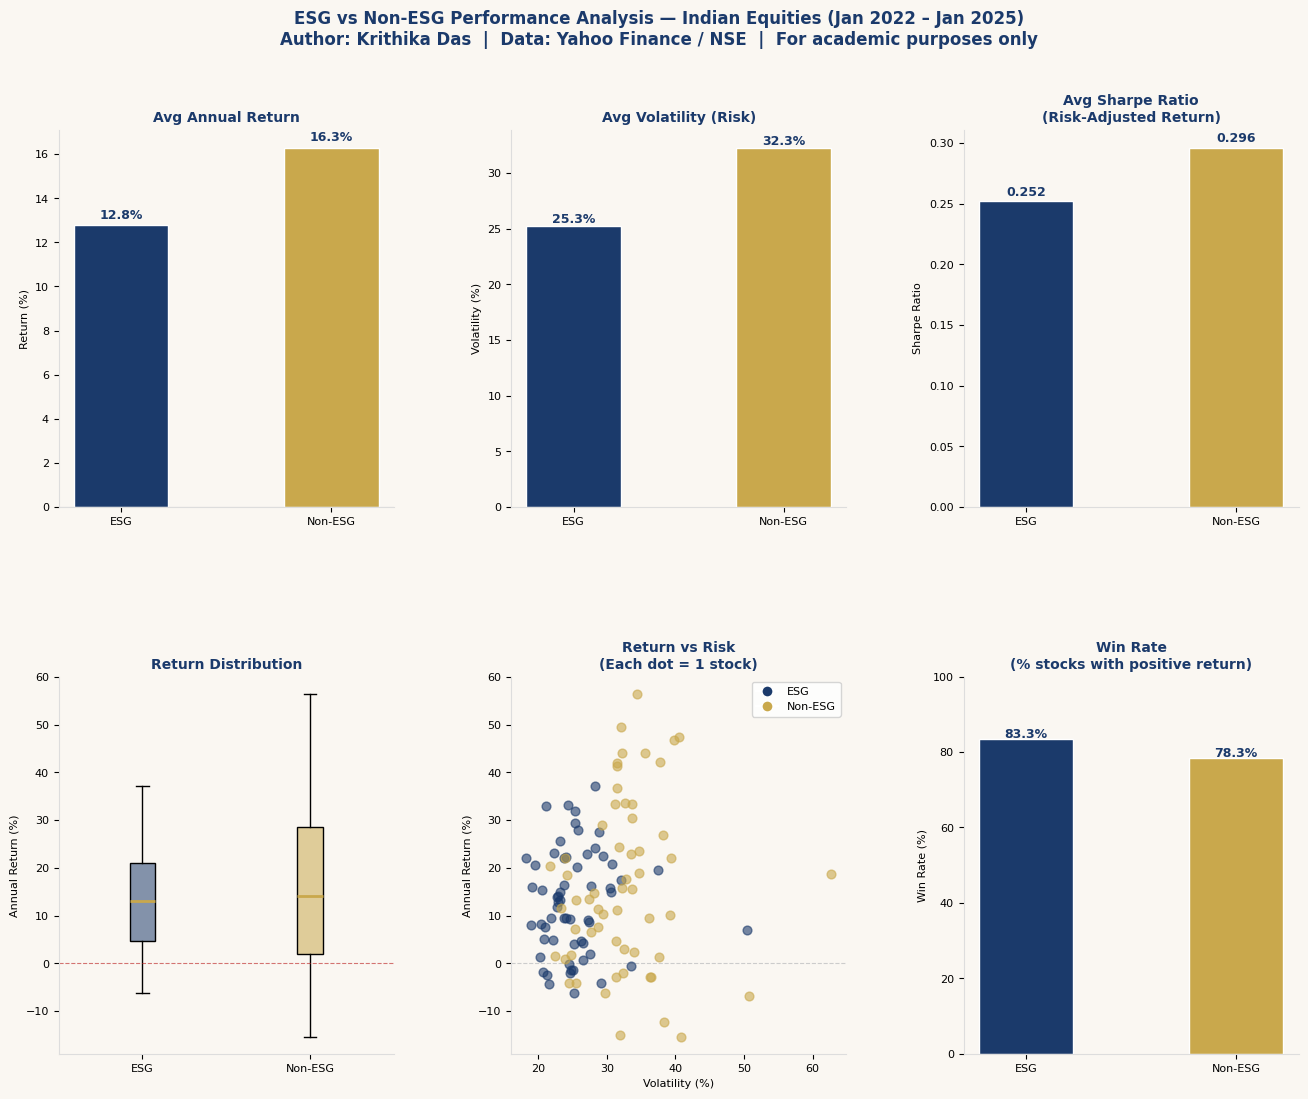


✓ Chart saved as esg_dashboard.png


In [21]:


CREAM = "#FAF7F2"
NAVY  = "#1B3A6B"
GOLD  = "#C9A84C"
RED   = "#B91C1C"

fig = plt.figure(figsize=(16, 12), facecolor=CREAM)
fig.suptitle(
    "ESG vs Non-ESG Performance Analysis — Indian Equities (Jan 2022 – Jan 2025)\n"
    "Author: Krithika Das  |  Data: Yahoo Finance / NSE  |  For academic purposes only",
    fontsize=12, fontweight='bold', color=NAVY, y=0.98
)

gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.45, wspace=0.35)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])

def style_ax(ax):
    ax.set_facecolor(CREAM)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#dddddd')
    ax.spines['bottom'].set_color('#dddddd')
    ax.tick_params(labelsize=8)

groups  = ["ESG", "Non-ESG"]
returns = [esg_group["Annual_Return_%"].mean(),
           nonesg_group["Annual_Return_%"].mean()]
colors  = [NAVY, GOLD]
bars = ax1.bar(groups, returns, color=colors, width=0.45, edgecolor='white')
for bar, val in zip(bars, returns):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
             f"{val:.1f}%", ha='center', fontsize=9, fontweight='bold', color=NAVY)
ax1.set_title("Avg Annual Return", fontsize=10, fontweight='bold', color=NAVY)
ax1.set_ylabel("Return (%)", fontsize=8)
ax1.axhline(0, color='#cccccc', linewidth=0.8)
style_ax(ax1)

vols = [esg_group["Volatility_%"].mean(),
        nonesg_group["Volatility_%"].mean()]
bars2 = ax2.bar(groups, vols, color=[NAVY, GOLD], width=0.45, edgecolor='white')
for bar, val in zip(bars2, vols):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
             f"{val:.1f}%", ha='center', fontsize=9, fontweight='bold', color=NAVY)
ax2.set_title("Avg Volatility (Risk)", fontsize=10, fontweight='bold', color=NAVY)
ax2.set_ylabel("Volatility (%)", fontsize=8)
style_ax(ax2)


sharpes = [esg_group["Sharpe"].mean(),
           nonesg_group["Sharpe"].mean()]
bars3 = ax3.bar(groups, sharpes, color=[NAVY, GOLD], width=0.45, edgecolor='white')
for bar, val in zip(bars3, sharpes):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f"{val:.3f}", ha='center', fontsize=9, fontweight='bold', color=NAVY)
ax3.set_title("Avg Sharpe Ratio\n(Risk-Adjusted Return)", fontsize=10,
              fontweight='bold', color=NAVY)
ax3.set_ylabel("Sharpe Ratio", fontsize=8)
style_ax(ax3)


data_to_plot = [esg_group["Annual_Return_%"].dropna().values,
                nonesg_group["Annual_Return_%"].dropna().values]
bp = ax4.boxplot(data_to_plot, labels=["ESG", "Non-ESG"],
                 patch_artist=True, notch=False,
                 medianprops=dict(color=GOLD, linewidth=2))
bp['boxes'][0].set_facecolor(NAVY + '88')
bp['boxes'][1].set_facecolor(GOLD + '88')
ax4.set_title("Return Distribution", fontsize=10, fontweight='bold', color=NAVY)
ax4.set_ylabel("Annual Return (%)", fontsize=8)
ax4.axhline(0, color=RED, linewidth=0.8, linestyle='--', alpha=0.6)
style_ax(ax4)


for _, row in esg_group.iterrows():
    ax5.scatter(row["Volatility_%"], row["Annual_Return_%"],
                color=NAVY, alpha=0.6, s=40, zorder=5)
for _, row in nonesg_group.iterrows():
    ax5.scatter(row["Volatility_%"], row["Annual_Return_%"],
                color=GOLD, alpha=0.6, s=40, zorder=5)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=NAVY,
           markersize=8, label='ESG'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=GOLD,
           markersize=8, label='Non-ESG')
]
ax5.legend(handles=legend_elements, fontsize=8)
ax5.axhline(0, color='#cccccc', linewidth=0.8, linestyle='--')
ax5.set_xlabel("Volatility (%)", fontsize=8)
ax5.set_ylabel("Annual Return (%)", fontsize=8)
ax5.set_title("Return vs Risk\n(Each dot = 1 stock)", fontsize=10,
              fontweight='bold', color=NAVY)
style_ax(ax5)


win_rates = [
    (esg_group["Annual_Return_%"] > 0).mean() * 100,
    (nonesg_group["Annual_Return_%"] > 0).mean() * 100
]
bars6 = ax6.bar(groups, win_rates, color=[NAVY, GOLD],
                width=0.45, edgecolor='white')
for bar, val in zip(bars6, win_rates):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f"{val:.1f}%", ha='center', fontsize=9, fontweight='bold', color=NAVY)
ax6.set_title("Win Rate\n(% stocks with positive return)", fontsize=10,
              fontweight='bold', color=NAVY)
ax6.set_ylabel("Win Rate (%)", fontsize=8)
ax6.set_ylim(0, 100)
style_ax(ax6)

plt.savefig("esg_dashboard.png", dpi=150, bbox_inches='tight', facecolor=CREAM)
plt.show()
print("\n✓ Chart saved as esg_dashboard.png")

In [22]:

all_returns.to_csv("esg_results.csv", index=False)
print("✓ Results saved to esg_results.csv")


print("\n" + "=" * 55)
print("  TOP 5 ESG PERFORMERS")
print("=" * 55)
print(esg_group.nlargest(5, "Annual_Return_%")
      [["Ticker","Annual_Return_%","Volatility_%","Sharpe"]]
      .to_string(index=False))

print("\n" + "=" * 55)
print("  TOP 5 NON-ESG PERFORMERS")
print("=" * 55)
print(nonesg_group.nlargest(5, "Annual_Return_%")
      [["Ticker","Annual_Return_%","Volatility_%","Sharpe"]]
      .to_string(index=False))

print("\n" + "=" * 55)
print("  BOTTOM 5 ESG PERFORMERS")
print("=" * 55)
print(esg_group.nsmallest(5, "Annual_Return_%")
      [["Ticker","Annual_Return_%","Volatility_%","Sharpe"]]
      .to_string(index=False))


print("\n" + "=" * 55)
print("  KEY FINDINGS SUMMARY")
print("=" * 55)
print(f"""
  1. Raw Returns: Non-ESG outperformed ESG by 3.5% annually
     (16.3% vs 12.8%) over Jan 2022 – Jan 2025.

  2. Risk: ESG stocks were significantly less volatile
     (25.3% vs 32.3%) — a 7% difference in annual
     volatility.

  3. Risk-Adjusted: Sharpe ratios were nearly identical
     (0.252 vs 0.296) — on a per-unit-of-risk basis,
     both groups performed similarly.

  4. Statistical significance: The return gap is NOT
     statistically significant (p = 0.198). We cannot
     conclude ESG stocks genuinely underperform.

  5. Win rate: ESG stocks had a higher % of positive
     returns (83.3% vs 78.3%) — more consistent,
     even if average gains were smaller.

  CONCLUSION: ESG investing in India does not
  significantly hurt returns but does meaningfully
  reduce portfolio volatility. For risk-conscious
  investors, ESG screens offer a comparable
  risk-adjusted return with a smoother ride.
""")
print("=" * 55)

✓ Results saved to esg_results.csv

  TOP 5 ESG PERFORMERS
       Ticker  Annual_Return_%  Volatility_%  Sharpe
 COALINDIA.NS        37.153732     28.334500   1.082
BAJAJ-AUTO.NS        33.235587     24.335042   1.099
BHARTIARTL.NS        32.865954     21.193486   1.244
      NTPC.NS        31.933434     25.313870   1.005
 EICHERMOT.NS        29.398520     25.419901   0.901

  TOP 5 NON-ESG PERFORMERS
       Ticker  Annual_Return_%  Volatility_%  Sharpe
       BEL.NS        56.501764     34.366045   1.455
CUMMINSIND.NS        49.480154     32.024571   1.342
    RECLTD.NS        47.370684     40.585501   1.007
       PFC.NS        46.697597     39.724271   1.012
     CANBK.NS        44.102756     32.210404   1.167

  BOTTOM 5 ESG PERFORMERS
       Ticker  Annual_Return_%  Volatility_%  Sharpe
     WIPRO.NS        -6.232710     25.270947  -0.504
ASIANPAINT.NS        -4.257237     21.566150  -0.499
      LTIM.NS        -4.118446     29.156149  -0.364
     DABUR.NS        -2.454677     21.

In [23]:
import json

data = {
    "esg": {
        "Annual_Return_%": esg_group["Annual_Return_%"].dropna().tolist(),
        "Volatility_%": esg_group["Volatility_%"].dropna().tolist(),
        "Sharpe": esg_group["Sharpe"].dropna().tolist()
    },
    "nonesg": {
        "Annual_Return_%": nonesg_group["Annual_Return_%"].dropna().tolist(),
        "Volatility_%": nonesg_group["Volatility_%"].dropna().tolist(),
        "Sharpe": nonesg_group["Sharpe"].dropna().tolist()
    }
}
print(json.dumps(data))

{"esg": {"Annual_Return_%": [6.915079740272634, 19.52959519044619, 9.293876571629456, -4.257237470452113, 16.317515925190907, 33.235587266202195, 4.743515845212265, 8.641453072461536, 32.865953997596264, 24.061311490432267, 15.349040295393035, 13.797355820110102, 37.15373214418689, -2.454676954476198, 8.989338689702686, 7.701589070151238, 29.39851968292544, 14.891810634218183, 9.549217320689984, 8.214487124382552, 3.934812913348229, 27.957819263549077, 17.540556214652337, 1.284694140376308, 15.996004355649696, 9.428650646229153, 4.298962284392105, -0.6028158997549715, -1.3296332893830476, 22.165311092405982, 16.2580038910914, 4.900052920487052, 21.96628137573895, -4.118446135583065, 22.87040902166797, 23.15947605000195, 27.417465012827936, 8.02313037183524, 31.933434364717716, 20.80464516115359, -1.9869549626778782, 5.1635979028835655, 20.24160369063972, 9.46367574300908, -1.5152523951823427, 14.11718790192067, 22.34211321058721, -0.16587484856872559, 22.43881364824647, 20.508449090524